In [53]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

## Image autocorrelation function defined below

In [72]:
def im_corr(im, filter=False, filtersize=80, bin=True, binsize=2):
    '''
    Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
        
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation
    '''
    # Crop image
    image = im[:1440, :1440]
        
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)
        
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    #return ONLY rav_corr **b/c I don't need corr_im** (CHANGE THIS IF YOU DO) 
    return rav_corr

###not sure if this function is necessary
def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

###define the double exponential we use to fit SIA curves
def double_exponential(x, A, B, l1, l2):
    return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))

def single_exponential(x, As, ls):
    return (As*np.exp(-x/ls)) 

def if_single_exp(popt):
    if popt[1] == 0:
        single_popt = [popt[0], popt[2]]
        fit_values = single_exponential(x_fit_values, *single_popt)
        return fit_values
    else:
        fit_values = double_exponential(x_fit_values, *popt)
        return fit_values

###define function to systimatically reduce the fit length until the fit parameters meet the specific criteria
def check_fits(A, B, l1, l2, y_array):
    if A == br_A:
        row = "(br) "
    elif A == mr_A:
        row = "(mr) "
    else:
        row = "(tr) "
    j=1
    if (A < 0.1) or (B < 0.1) or (l1 > 135.0) or (l2 > 135.0): ##this line sets the specific criteria for fit params to meet
        try_again = True
        print("     poor fit at "+row+ time)
        while try_again:
            new_fit_lim = fit_lim - 2*j
            x_fit_lim = all_xvalues[new_fit_lim]
            popt, pcov = curve_fit(double_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], p0 = [0.5,0.5,5.0,20.0])
            print("        "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
            A, B, l1, l2 = tuple(popt)
            x_fit_values = np.linspace(0.364, all_xvalues[new_fit_lim], 1000)
            if j == 25:
                print("   poor fit at "+row+ time + " can't be fixed :(")
                try_again = False
                x_fit_lim = all_xvalues[fit_lim]
                x_fit_values = np.linspace(0.364, all_xvalues[fit_lim], 1000)
                A, B, l1, l2 =  0, 0, 0, 0
            elif (A < 0.1) or (B < 0.1) or (l1 > 135.0) or (l2 > 135.0):
                try_again = True
                j = j+1
            else:
                try_again = False
                print("  yay!! good fit at "+row+time)
                print("  "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
    return [A, B, l1, l2]

def check_fits(A, B, l1, l2, y_array, retry_num):
    if A == br_A:
        row = "(br) "
    elif A == mr_A:
        row = "(mr) "
    else:
        row = "(tr) "
    j=1
    if (A < 0.1) or (B < 0.1) or (l1 > 135.0) or (l2 > 135.0): ##this line sets the specific criteria for fit params to meet
        try_again = True
        print("     poor fit at "+row+ time)
        while try_again:
            new_fit_lim = fit_lim - (2*j +1)
            x_fit_lim = all_xvalues[new_fit_lim]
            popt, pcov = curve_fit(double_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], p0 = [0.5,0.5,4.0,30.0])
            print("        "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
            A, B, l1, l2 = tuple(popt)
            x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
            if j == (retry_num-1):
                print("   poor fit at "+row+ time + " --> try single exponential fit")
                try_again = False
                try_single = True
                i = 0
                while try_single:
                    new_fit_lim = fit_lim - (2*i +1)
                    x_fit_lim = all_xvalues[new_fit_lim]
                    popt, pcov = curve_fit(single_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], p0 = [0.5,7.0])
                    print("           "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: As=%5.3f, ls=%5.3f' % tuple(popt))
                    As, ls = tuple(popt)
                    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
                
                    if i == retry_num:
                        print("           poor fit at "+row+ time + " can't be fixed :(")
                        try_again = False
                        x_fit_lim = all_xvalues[fit_lim]
                        x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000)
                        A, B, l1, l2 =  0, 0, 0, 0
                        #return A, B, l1, l2, popt
                    elif (As < 0.1) or (ls > 135.0):
                        try_again = True
                        i = i+1
                    else:
                        try_single = False
                        print("       yay!! good fit at "+row+time)
                        print("       "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: As=%5.3f, ls=%5.3f' % tuple(popt))
                        A, B, l1, l2 =  As, 0, ls, 0
                        #return A, B, l1, l2, popt
            elif (A < 0.1) or (B < 0.1) or (l1 > 135.0) or (l2 > 135.0):
                try_again = True
                j = j+1
            else:
                try_again = False
                print("  yay!! good fit at "+row+time)
                print("  "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
    return [A, B, l1, l2]

def avg_and_std_error(tup_key, br_array, mr_array, tr_array, avg_array, stderror_array):
    for i in range(len(br_array)):
        if (br_array[i][tup_key]!=0) and (mr_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + mr_array[i][tup_key] +tr_array[i][tup_key])/3
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2)+((mr_array[i][tup_key]-avg_array[i])**2)
                                       +((tr_array[i][tup_key]-avg_array[i])**2))/3))/np.sqrt(3)

        elif (br_array[i][tup_key]==0) and (mr_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (mr_array[i][tup_key] + tr_array[i][tup_key])/2 
            stderror_array[i] = (np.sqrt((((mr_array[i][tup_key]-avg_array[i])**2) 
                                          +((tr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)

        elif (mr_array[i][tup_key]==0) and (br_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + tr_array[i][tup_key])/2
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2) 
                                          +((tr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)

        elif (tr_array[i][tup_key]==0) and (br_array[i][tup_key]!=0) and (mr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + mr_array[i][tup_key])/2
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2) 
                                          +((mr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)
        
        elif (br_array[i][tup_key]==0) and (mr_array[i][tup_key]==0):
            avg_array[i] = tr_array[i][tup_key]
            stderror_array[i] = 0
        elif (mr_array[i][tup_key]==0) and (tr_array[i][tup_key]==0):
            avg_array[i] = br_array[i][tup_key]
            stderror_array[i] = 0
        elif (br_array[i][tup_key]==0 and tr_array[i][tup_key]==0):
            avg_array[i] = mr_array[i][tup_key]
            stderror_array[i] = 0

def check_A_B_sum(br_A, br_B, mr_A, mr_B, tr_A, tr_B):
    if ((br_A + br_B) != 1.0):
        print("------> WTF? br_A + br_B = "+str((br_A + br_B)))
    elif ((mr_A + mr_B) != 1.0):
        print("------> WTF? mr_A + mr_B = "+str((mr_A + mr_B)))
    elif ((tr_A + tr_B) != 1.0):
        print("------> WTF? tr_A + tr_B = "+str((tr_A + tr_B)))

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

avg_and_std_error(1,br_longlengths, mr_longlengths, tr_longlengths, avg_L2, stderror_L2)

for i in range(len(br_shortlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                              label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    if stderror_L2[i] != 0:
        ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,130)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

#fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

#fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    br_short_plot, = ax.plot(time_array[i], br_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    mr_short_plot, = ax.plot(time_array[i], mr_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -mr")
    tr_short_plot, = ax.plot(time_array[i], tr_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -tr")
    
    br_long_plot, = ax.plot(time_array[i], br_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                label= "long (L2)")
    mr_long_plot, = ax.plot(time_array[i], mr_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                label= "long (L2) -mr")
    tr_long_plot, = ax.plot(time_array[i], tr_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                label= "long (L2) -tr")
    
plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,135)

plt.title(title, fontsize=font_size)
ax.legend(handles =[br_short_plot, br_long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

In [55]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "8-15-22_s2_EA,WT,1-3WT"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 27 files
9
 0 	 bottom_row_t1.tif
 1 	 bottom_row_t2.tif
 2 	 bottom_row_t3.tif
 3 	 bottom_row_t4.tif
 4 	 bottom_row_t5.tif
 5 	 bottom_row_t6.tif
 6 	 bottom_row_t7.tif
 7 	 bottom_row_t8.tif
 8 	 bottom_row_t9.tif
 9 	 middle_row_t1.tif
 10 	 middle_row_t2.tif
 11 	 middle_row_t3.tif
 12 	 middle_row_t4.tif
 13 	 middle_row_t5.tif
 14 	 middle_row_t6.tif
 15 	 middle_row_t7.tif
 16 	 middle_row_t8.tif
 17 	 middle_row_t9.tif
 18 	 top_row_t1.tif
 19 	 top_row_t2.tif
 20 	 top_row_t3.tif
 21 	 top_row_t4.tif
 22 	 top_row_t5.tif
 23 	 top_row_t6.tif
 24 	 top_row_t7.tif
 25 	 top_row_t8.tif
 26 	 top_row_t9.tif


In [5]:
###### # specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
time_array =  [0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#[0.5, 4.5, 8, 12, 20, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#[0.5, 3.2, 17.75, 20, 22, 24.25, 26, 41.75, 44]
#[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 800
pixel_size = 0.364 # 4*0.091 = 0.364

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)
print(arr_length)

Z:\Gregor L\__Kai Colloids\8-15-22_s2_EA,WT,1-3WT\all tiff files\bottom_row_t1.tif


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


(5, 1440, 1920)
5
9


In [ ]:
from skimage.filters import threshold_otsu, threshold_local

def filtimage(image, filtersize):
    image = (image/100)**1.6 #(array)^1.6 to increase contrast (i think this works?)
    image = (image*10) +1000
    image = (image*1.0) - ((uf(image,filtersize))*1)  #(image) - unifrom-filtered(image) subtracts background
    image = image + 1500  #return pixel array values back to their original range 
    return image

raw_image = tiff_file.imread(files[38],key=[2])
image = filtimage(raw_image, filtersize= 1000)

block_size = 401

raw_global_thresh = threshold_otsu(raw_image)
raw_binary_global = raw_image > raw_global_thresh
raw_local_thresh = threshold_local(raw_image, block_size, offset= -50)
raw_binary_local = raw_image > raw_local_thresh

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh
local_thresh = threshold_local(image, block_size, offset= -50)
#binary_local = Image.fromarray((image > local_thresh))
binary_local = 1*(image > local_thresh)

fig, ax = plt.subplots(2, 3, figsize=(9,5))
#ax = axes.ravel()
plt.gray()

ax[0, 0].imshow(raw_image)
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')
ax[0, 1].imshow(raw_binary_global)
ax[0, 1].set_title('Global thresholding')
ax[0, 1].axis('off')
ax[0, 2].imshow(raw_binary_local)
ax[0, 2].set_title('Local thresholding')
ax[0, 2].axis('off')

ax[1, 0].imshow(image)
ax[1, 0].set_title('filtered')
ax[1, 0].axis('off')
ax[1, 1].imshow(binary_global)
ax[1, 1].set_title('Global thresholding')
ax[1, 1].axis('off')
ax[1, 2].imshow(binary_local)
ax[1, 2].set_title('Local thresholding')
ax[1, 2].axis('off')

plt.tight_layout(pad=.2)
plt.show()

figure, axes = plt.subplots(1, 3, figsize=(9,3.5))
axes[0].hist(raw_image.ravel(), bins=256)
axes[0].axvline(raw_global_thresh, color='r')
axes[0].set_title('original image global threshold')
axes[1].hist(image.ravel(), bins=256)
axes[1].axvline(global_thresh, color='r')
axes[1].set_title('filtered image global threshold')

num_binary_local = np.zeros((1440,1920))

axes[2].hist(binary_local.ravel(), bins="auto")
axes[2].set_title('local thresholded image')
plt.tight_layout(pad=.4)
plt.show()

In [ ]:
from skimage.filters import threshold_otsu, threshold_local

block_size = 1051
offset_val = -20

image = tiff_file.imread(files[9],key=[0])
thresh = threshold_local(image, block_size, offset= offset_val)
binary_im = 1*(image > thresh)
binned_binary_im = (downscale_local_mean(binary_im, (2,2), cval=1))

ed_image = (image**0.2)*500
ed_thresh = threshold_local(ed_image, block_size, offset= offset_val)
ed_binary_im = 1*(ed_image > ed_thresh)

offset_binned_im = 1*((image*0.98) > (thresh+0))

fig, ax = plt.subplots(1, 4, figsize=(9.8,2.8))
#ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(binned_binary_im)
ax[1].set_title('thresholding')
ax[1].axis('off')
ax[2].imshow(ed_image)
ax[2].set_title('ed_image')
ax[2].axis('off')
ax[3].imshow(ed_binary_im)
ax[3].set_title('ed_binary_im')
ax[3].axis('off')

plt.tight_layout(pad=.2)
plt.show()

figure, axes = plt.subplots(1, 2, figsize=(10,3))
axes[0].hist(image.ravel(), bins=256)
#axes[0].axvline(raw_global_thresh, color='r')
axes[0].set_title('original image')
axes[1].hist(ed_image.ravel(), bins="auto")
axes[1].set_title('ed_image')

plt.show()

###################################################################################################
# makes new tiff files, each new tiff has all consecutive time points for each specific condition #
###################################################################################################
arr_length = int((len(files))/3)

for j in range(frames_per_tiff-1):
    frame_num = str(j+1)

    for i in range(arr_length):    
        br_frame1_im = tiff_file.imread(files[i],key=[j])
        mr_frame1_im = tiff_file.imread(files[i+arr_length],key=[j])
        tr_frame1_im = tiff_file.imread(files[i+(arr_length*2)],key=[j])
        #print(br_frame1_im.shape[0])
        if i==0:
            br_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            mr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
            tr_frame1 = np.zeros((arr_length, br_frame1_im.shape[0], br_frame1_im.shape[1]), dtype=np.uint16)
        br_frame1[i] = br_frame1_im
        mr_frame1[i] = mr_frame1_im
        tr_frame1[i] = tr_frame1_im

    tiff_file.imsave(data_dir2 +'br_'+frame_names[j]+'.tif', br_frame1)
    tiff_file.imsave(data_dir2 +'mr_'+frame_names[j]+'.tif', mr_frame1)
    tiff_file.imsave(data_dir2 +'tr_'+frame_names[j]+'.tif', tr_frame1)
    print(tr_frame1.shape)

#####################################################
# **optional** preview of tiff files to be analyzed #
#####################################################
br_frame1 = tiff_file.imread(data_dir2 +'tr_'+frame_names[0]+'.tif')

plt.figure(figsize=(10,10))    
for i in range (arr_length):
    ax = plt.subplot(4,3,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("frame %i" % int(i + 1), fontsize=10)
    ax.matshow(br_frame1[i], cmap = 'bone') #fig.set_cmap('hot') 
    plt.axis('off')
    plt.tight_layout(pad=.25)

In [6]:
im_array = [0.0] * int(len(files))
br_corr_rad_array = [0.0] * int(len(files))
mr_corr_rad_array = [0.0] * int(len(files))
tr_corr_rad_array = [0.0] * int(len(files))

all_xvalues = [0.0] * int(len(files))

<IPython.core.display.Javascript object>


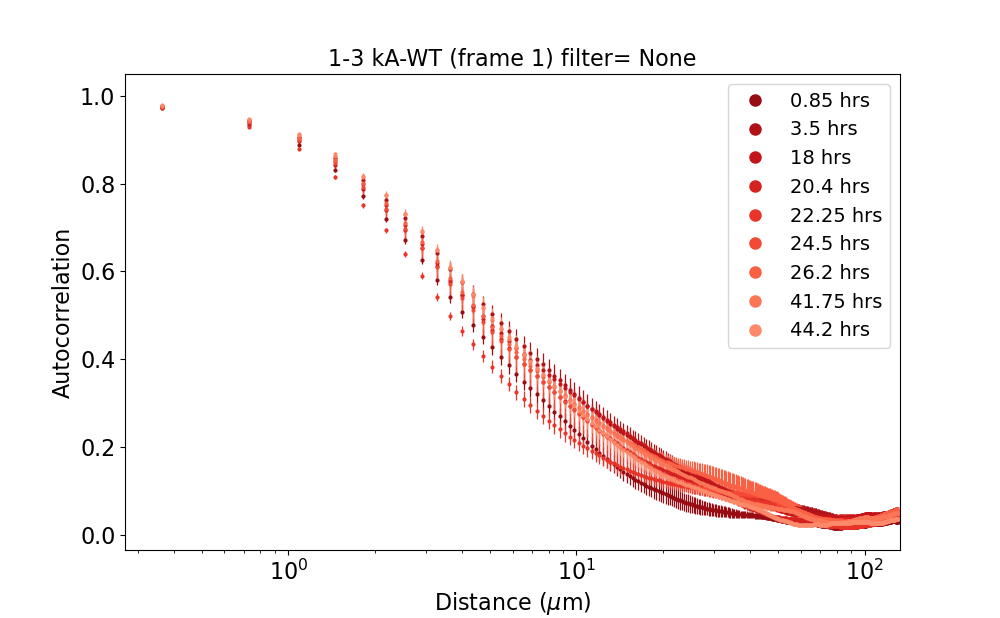

image size: 130.676 x 130.676 um, last x-value= 130.676


<ipython-input-8-376627dddbfe>:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [8]:
key = 0
cmap = matplotlib.cm.get_cmap('Reds')

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [9]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


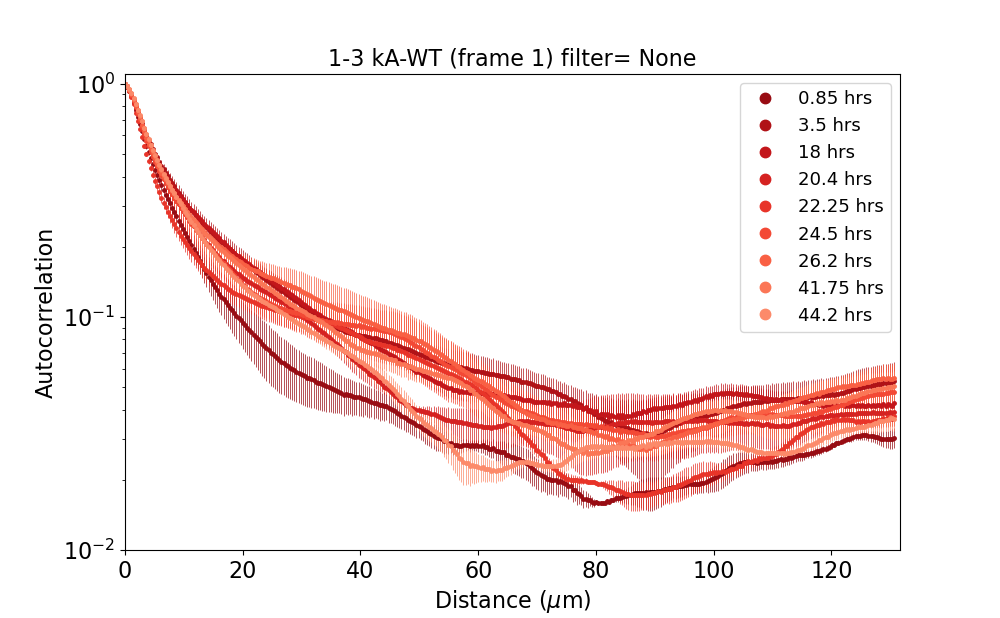

In [10]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


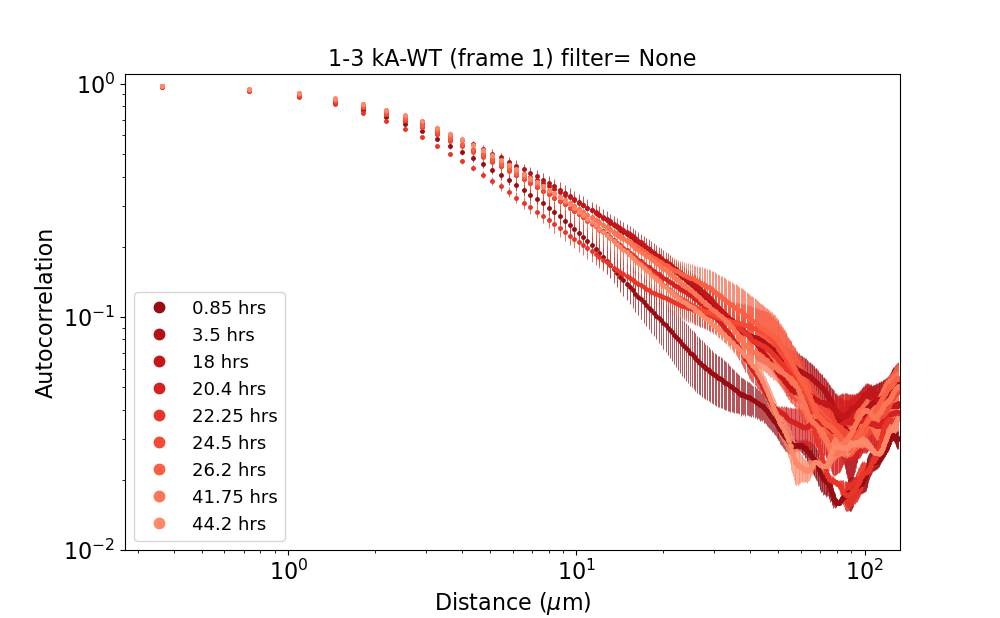

<ipython-input-11-789a4afed38a>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [11]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


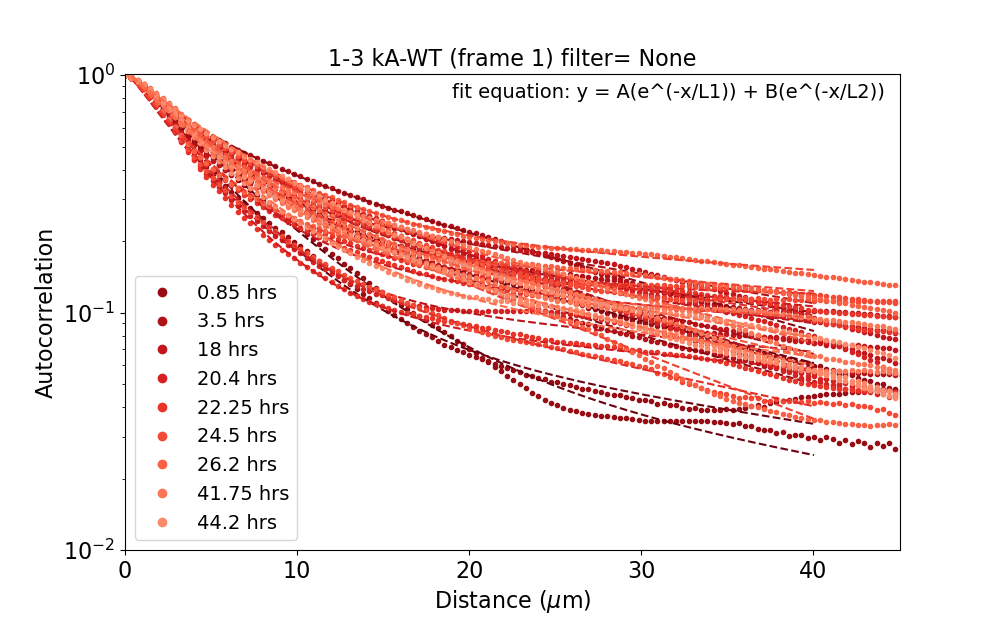

first x-value= 0.364, start fits from 0.364; fit until xlim = 40.040
Fits:
0.85 hrs-- br fit: A=0.955, B=0.095, l1=4.652, l2=38.823
0.85 hrs-- mr fit: A=0.732, B=0.315, l1=4.085, l2=24.459
0.85 hrs-- tr fit: A=0.955, B=0.076, l1=5.691, l2=34.948
     poor fit at (br) 0.85 hrs
     (br) 0.85 hrs-- xlim= 39.312, fit: A=0.951, B=0.099, l1=4.625, l2=36.138
     poor fit at (br) 0.85 hrs
     (br) 0.85 hrs-- xlim= 38.583999999999996, fit: A=0.947, B=0.104, l1=4.599, l2=33.907
  yay!! good fit at (br) 0.85 hrs
  (br) 0.85 hrs-- xlim= 38.583999999999996, fit: A=0.947, B=0.104, l1=4.599, l2=33.907
     poor fit at (tr) 0.85 hrs
     (tr) 0.85 hrs-- xlim= 39.312, fit: A=0.951, B=0.081, l1=5.663, l2=32.643
     poor fit at (tr) 0.85 hrs
     (tr) 0.85 hrs-- xlim= 38.583999999999996, fit: A=0.946, B=0.086, l1=5.632, l2=30.367
     poor fit at (tr) 0.85 hrs
     (tr) 0.85 hrs-- xlim= 37.856, fit: A=0.940, B=0.093, l1=5.593, l2=28.010
     poor fit at (tr) 0.85 hrs
     (tr) 0.85 hrs-- xlim= 37.128

Text(0.5, 1.0, '1-3 kA-WT (frame 1) filter= None')

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [13]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [14]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

br_l2= 33.907, br_l1= 4.599,   mr_l2= 24.459, mr_1= 4.085,   tr_l2= 25.627, tr_l1 5.545,
br_l2= 45.484, br_l1= 4.382,   mr_l2= 21.927, mr_1= 4.966,   tr_l2= 21.301, tr_l1 3.780,
br_l2= 35.293, br_l1= 3.307,   mr_l2= 23.584, mr_1= 4.184,   tr_l2= 18.275, tr_l1 3.792,
br_l2= 62.248, br_l1= 3.877,   mr_l2= 17.552, mr_1= 3.459,   tr_l2= 47.452, tr_l1 5.948,
br_l2= 64.838, br_l1= 3.907,   mr_l2= 65.362, mr_1= 4.157,   tr_l2= 66.156, tr_l1 3.924,
br_l2= 28.200, br_l1= 3.930,   mr_l2= 43.149, mr_1= 5.060,   tr_l2= 113.419, tr_l1 6.549,
br_l2= 74.474, br_l1= 3.774,   mr_l2= 15.706, mr_1= 3.870,   tr_l2= 93.030, tr_l1 5.722,
br_l2= 107.209, br_l1= 5.434,   mr_l2= 22.597, mr_1= 3.666,   tr_l2= 25.488, tr_l1 4.787,
br_l2= 28.266, br_l1= 4.851,   mr_l2= 47.746, mr_1= 5.014,   tr_l2= 53.508, tr_l1 6.975,


<IPython.core.display.Javascript object>


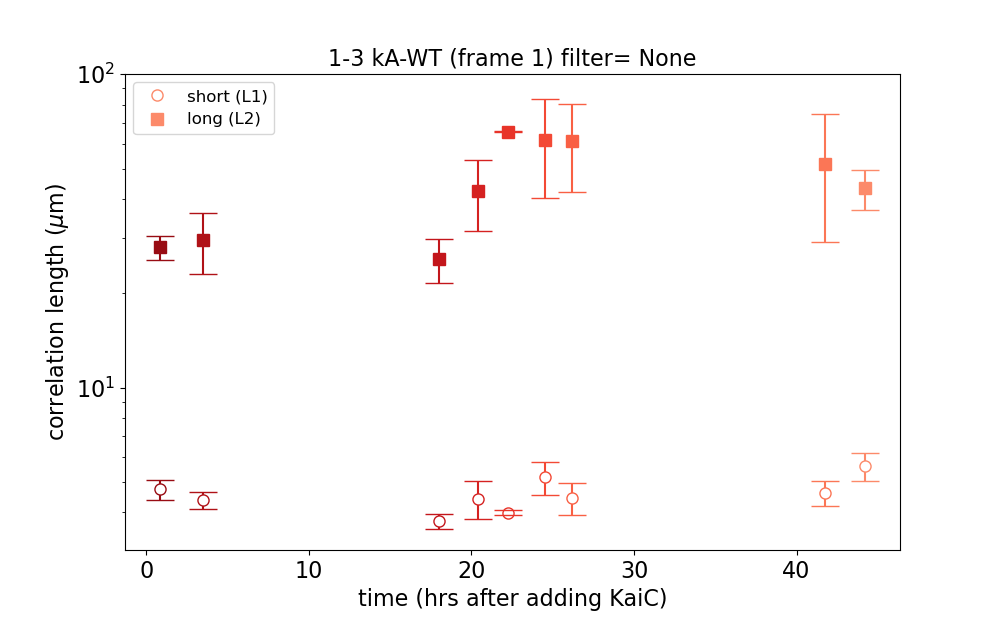

<ipython-input-15-52d3bbe172ad>:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100)


In [15]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [17]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

[0.1735246  0.36616462 0.40802248 0.29340256 0.15752023 0.18775593
 0.29963669 0.29460852 0.18567027]
[0.05761979 0.07591616 0.04547603 0.10353109 0.02209083 0.02394251
 0.06429948 0.07101615 0.02486405]
[0.87018679 0.67851423 0.63865978 0.7624681  0.90263037 0.85327191
 0.75508061 0.7614173  0.86257989]
[0.05671037 0.07949405 0.05052961 0.10667418 0.0284967  0.0263706
 0.06524923 0.07109248 0.02356375]


<IPython.core.display.Javascript object>


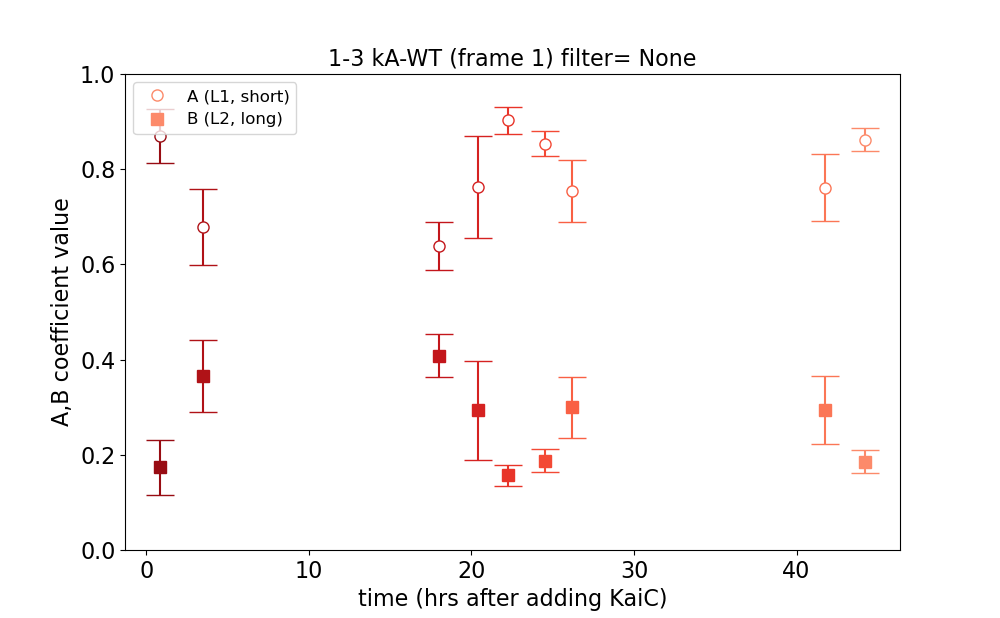

In [18]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [19]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

<IPython.core.display.Javascript object>


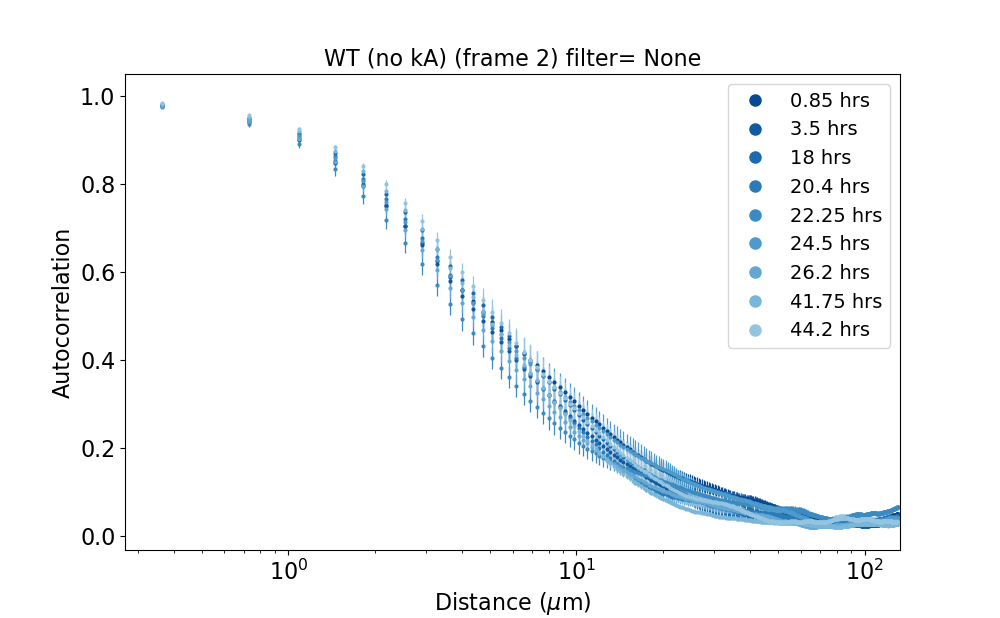

image size: 130.676 x 130.676 um, last x-value= 130.676


<ipython-input-20-4393d45014b6>:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [20]:
cmap = matplotlib.cm.get_cmap('Blues')
key = 1

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [21]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


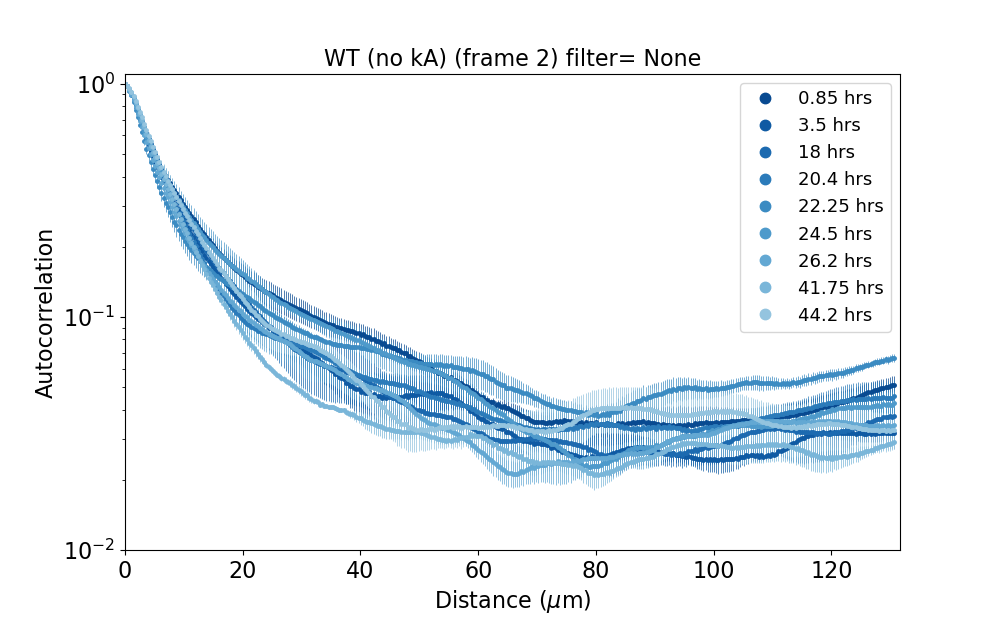

In [22]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


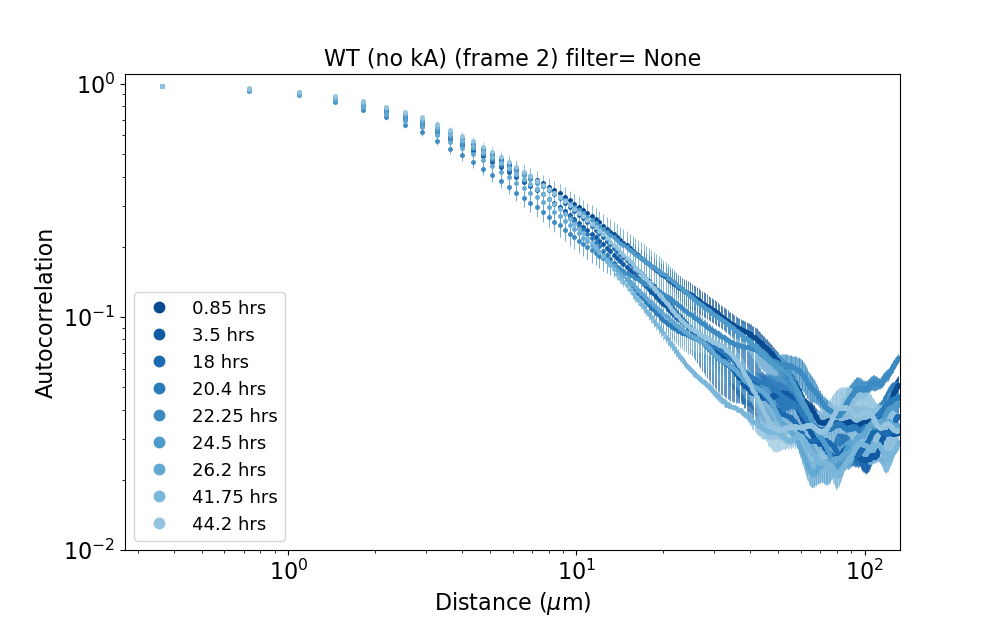

<ipython-input-23-789a4afed38a>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [23]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


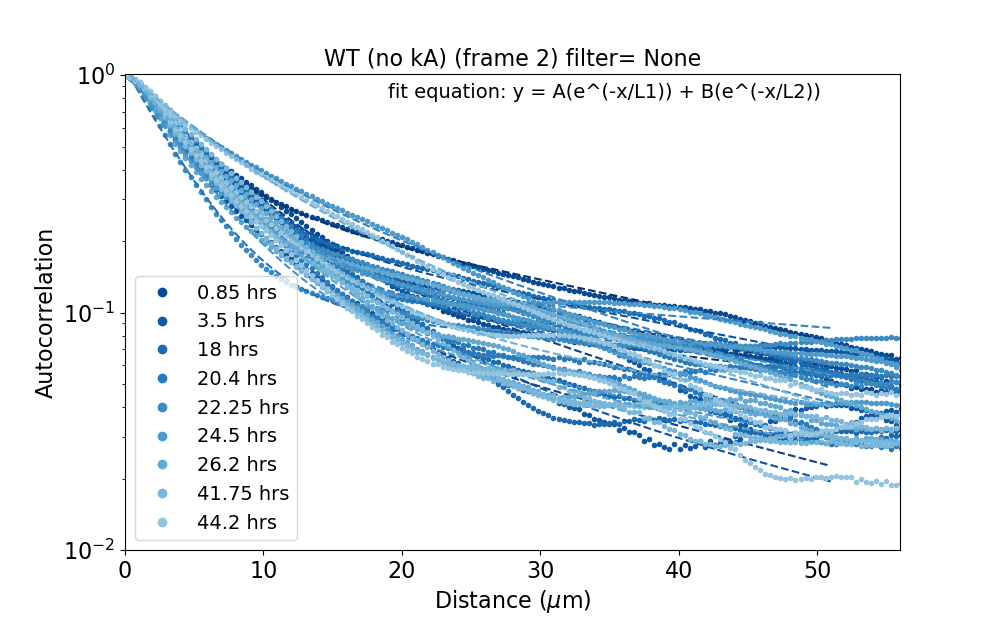

first x-value= 0.364, start fits from 0.364; fit until xlim = 50.960
Fits:
0.85 hrs-- br fit: A=0.837, B=0.206, l1=4.915, l2=40.800
0.85 hrs-- mr fit: A=0.728, B=0.320, l1=4.291, l2=35.353
0.85 hrs-- tr fit: A=0.906, B=0.098, l1=6.874, l2=95.557
     poor fit at (tr) 0.85 hrs
        (tr) 0.85 hrs-- xlim= 50.232, fit: A=0.908, B=0.096, l1=6.894, l2=101.138
        (tr) 0.85 hrs-- xlim= 49.504, fit: A=0.909, B=0.094, l1=6.911, l2=106.730
        (tr) 0.85 hrs-- xlim= 48.775999999999996, fit: A=0.910, B=0.093, l1=6.925, l2=111.703
        (tr) 0.85 hrs-- xlim= 48.048, fit: A=0.911, B=0.092, l1=6.935, l2=115.431
        (tr) 0.85 hrs-- xlim= 47.32, fit: A=0.911, B=0.092, l1=6.937, l2=116.440
        (tr) 0.85 hrs-- xlim= 46.592, fit: A=0.911, B=0.092, l1=6.936, l2=115.974
        (tr) 0.85 hrs-- xlim= 45.864, fit: A=0.911, B=0.093, l1=6.929, l2=113.242
        (tr) 0.85 hrs-- xlim= 45.135999999999996, fit: A=0.910, B=0.094, l1=6.920, l2=109.577
        (tr) 0.85 hrs-- xlim= 44.408, fit: A

<ipython-input-72-94f0c0ddfb3e>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))
<ipython-input-72-94f0c0ddfb3e>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))
<ipython-input-72-94f0c0ddfb3e>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))


        (tr) 26.2 hrs-- xlim= 43.68, fit: A=0.978, B=0.063, l1=6.424, l2=110.624
        (tr) 26.2 hrs-- xlim= 42.952, fit: A=0.978, B=0.063, l1=6.428, l2=114.024
        (tr) 26.2 hrs-- xlim= 42.224, fit: A=0.979, B=0.062, l1=6.435, l2=119.567
        (tr) 26.2 hrs-- xlim= 41.496, fit: A=0.980, B=0.061, l1=6.445, l2=130.188
        (tr) 26.2 hrs-- xlim= 40.768, fit: A=0.982, B=0.059, l1=6.458, l2=147.296
        (tr) 26.2 hrs-- xlim= 40.04, fit: A=0.983, B=0.057, l1=6.476, l2=182.124
        (tr) 26.2 hrs-- xlim= 39.312, fit: A=0.986, B=0.054, l1=6.499, l2=262.611
        (tr) 26.2 hrs-- xlim= 38.583999999999996, fit: A=0.989, B=0.051, l1=6.525, l2=560.918
        (tr) 26.2 hrs-- xlim= 37.856, fit: A=0.991, B=0.049, l1=6.546, l2=11027187.731
        (tr) 26.2 hrs-- xlim= 37.128, fit: A=0.991, B=0.049, l1=6.537, l2=22491189.851
        (tr) 26.2 hrs-- xlim= 36.4, fit: A=0.991, B=0.050, l1=6.530, l2=75784998.912
        (tr) 26.2 hrs-- xlim= 35.672, fit: A=0.999, B=0.040, l1=6.629, l2=-

        (br) 44.2 hrs-- xlim= 36.4, fit: A=1.025, B=0.044, l1=5.788, l2=460258770.155
        (br) 44.2 hrs-- xlim= 35.672, fit: A=1.025, B=0.044, l1=5.789, l2=505122399.525
        (br) 44.2 hrs-- xlim= 34.944, fit: A=1.025, B=0.044, l1=5.793, l2=309685209.154
        (br) 44.2 hrs-- xlim= 34.216, fit: A=1.025, B=0.044, l1=5.798, l2=212413519.066
        (br) 44.2 hrs-- xlim= 33.488, fit: A=1.026, B=0.043, l1=5.806, l2=380912332.534
        (br) 44.2 hrs-- xlim= 32.76, fit: A=1.026, B=0.043, l1=5.815, l2=397483597.007
   poor fit at (br) 44.2 hrs can't be fixed :(


<ipython-input-72-94f0c0ddfb3e>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))
<ipython-input-72-94f0c0ddfb3e>:38: RuntimeWarning: divide by zero encountered in true_divide
  return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))


Text(0.5, 1.0, 'WT (no kA) (frame 2) filter= None')

In [75]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -220 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_popt = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    #print(br_popt)
    mr_popt = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_popt = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [76]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

br_l2= 40.800, br_l1= 4.915,   mr_l2= 35.353, mr_1= 4.291,   tr_l2= 83.433, tr_l1 6.833,
br_l2= 28.538, br_l1= 4.769,   mr_l2= 23.049, mr_1= 4.939,   tr_l2= 61.034, tr_l1 5.727,
br_l2= 38.956, br_l1= 4.574,   mr_l2= 29.667, mr_1= 6.537,   tr_l2= 0.000, tr_l1 0.000,
br_l2= 55.415, br_l1= 4.889,   mr_l2= 0.000, mr_1= 0.000,   tr_l2= 0.000, tr_l1 0.000,
br_l2= 111.427, br_l1= 3.795,   mr_l2= 39.272, mr_1= 4.126,   tr_l2= 40.457, tr_l1 4.752,
br_l2= 31.322, br_l1= 4.050,   mr_l2= 101.026, mr_1= 4.937,   tr_l2= 23.571, tr_l1 6.043,
br_l2= 36.508, br_l1= 4.547,   mr_l2= 37.795, mr_1= 4.290,   tr_l2= 0.000, tr_l1 0.000,
br_l2= 0.000, br_l1= 0.000,   mr_l2= 39.357, mr_1= 5.670,   tr_l2= 0.000, tr_l1 0.000,
br_l2= 0.000, br_l1= 0.000,   mr_l2= 43.731, mr_1= 5.563,   tr_l2= 23.605, tr_l1 6.530,


<IPython.core.display.Javascript object>


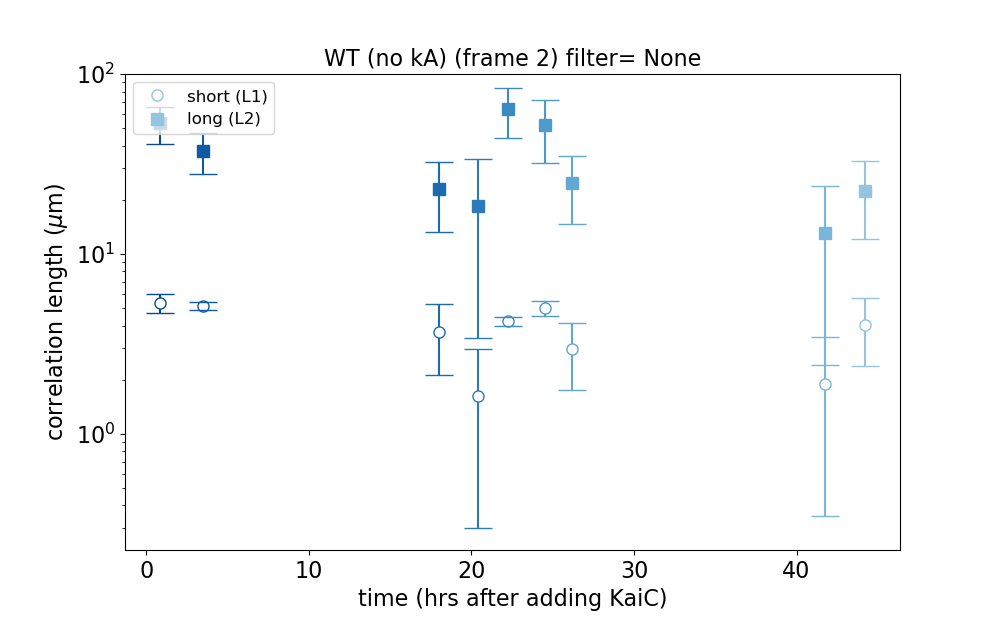

<ipython-input-77-8fcf2c7429b8>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,100)


In [77]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

#fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
key = 2
cmap = matplotlib.cm.get_cmap('Greens')

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
key = 3
cmap = matplotlib.cm.get_cmap('Greys')

t_f = False #True #False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()